In [8]:
!kaggle datasets download -d CooperUnion/cardataset
!unzip cardataset.zip -d data/

/bin/bash: /home/hilbert/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
100%|█████████████████████████████████████████| 103k/103k [00:00<00:00, 694kB/s]
100%|█████████████████████████████████████████| 103k/103k [00:00<00:00, 693kB/s]


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns   

In [12]:
df = pd.read_csv("data/data.csv")
print(df.shape)
df.info()  

(11914, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11914 non-null  object 
 1   Model              11914 non-null  object 
 2   Year               11914 non-null  int64  
 3   Engine Fuel Type   11911 non-null  object 
 4   Engine HP          11845 non-null  float64
 5   Engine Cylinders   11884 non-null  float64
 6   Transmission Type  11914 non-null  object 
 7   Driven_Wheels      11914 non-null  object 
 8   Number of Doors    11908 non-null  float64
 9   Market Category    8172 non-null   object 
 10  Vehicle Size       11914 non-null  object 
 11  Vehicle Style      11914 non-null  object 
 12  highway MPG        11914 non-null  int64  
 13  city mpg           11914 non-null  int64  
 14  Popularity         11914 non-null  int64  
 15  MSRP               11914 non-null  int64  
dtypes: float64

In [15]:
df.columns = df.columns.str.lower().str.replace(" ", "_")

In [20]:
strings = list(df.dtypes[df.dtypes == "object"].index)
print(strings)

['make', 'model', 'engine_fuel_type', 'transmission_type', 'driven_wheels', 'market_category', 'vehicle_size', 'vehicle_style']


In [21]:
for c in strings:
    df[c] = df[c].str.lower().str.replace(" ", "_")

## analisis de datos explicativos

In [27]:
for c in df:
    print(c)
    print(f"uniques: {df[c].nunique()}")
    print(df[c].unique()[:5])
    print()

make
uniques: 48
['bmw' 'audi' 'fiat' 'mercedes-benz' 'chrysler']

model
uniques: 914
['1_series_m' '1_series' '100' '124_spider' '190-class']

year
uniques: 28
[2011 2012 2013 1992 1993]

engine_fuel_type
uniques: 10
['premium_unleaded_(required)' 'regular_unleaded'
 'premium_unleaded_(recommended)' 'flex-fuel_(unleaded/e85)' 'diesel']

engine_hp
uniques: 356
[335. 300. 230. 320. 172.]

engine_cylinders
uniques: 9
[ 6.  4.  5.  8. 12.]

transmission_type
uniques: 5
['manual' 'automatic' 'automated_manual' 'direct_drive' 'unknown']

driven_wheels
uniques: 4
['rear_wheel_drive' 'front_wheel_drive' 'all_wheel_drive'
 'four_wheel_drive']

number_of_doors
uniques: 3
[ 2.  4.  3. nan]

market_category
uniques: 71
['factory_tuner,luxury,high-performance' 'luxury,performance'
 'luxury,high-performance' 'luxury' 'performance']

vehicle_size
uniques: 3
['compact' 'midsize' 'large']

vehicle_style
uniques: 16
['coupe' 'convertible' 'sedan' 'wagon' '4dr_hatchback']

highway_mpg
uniques: 59
[26 28

<Axes: xlabel='msrp', ylabel='Count'>

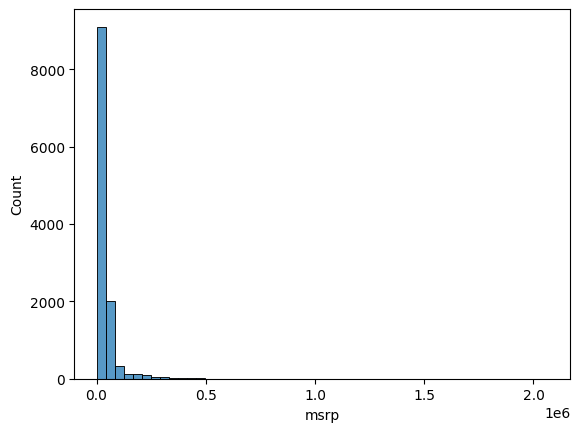

In [31]:
sns.histplot(df.msrp, bins=50)

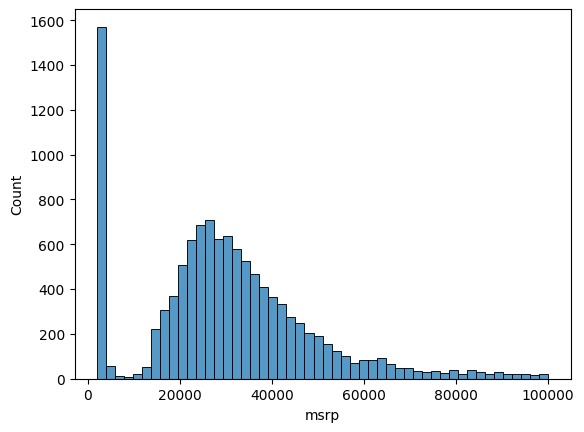

In [33]:
sns.histplot(df.msrp[df.msrp < 100_000], bins=50);

In [34]:
price_logs = np.log1p(df.msrp)
price_logs

0        10.739349
1        10.612779
2        10.500977
3        10.290483
4        10.448744
           ...    
11909    10.739024
11910    10.945018
11911    10.832122
11912    10.838031
11913    10.274913
Name: msrp, Length: 11914, dtype: float64

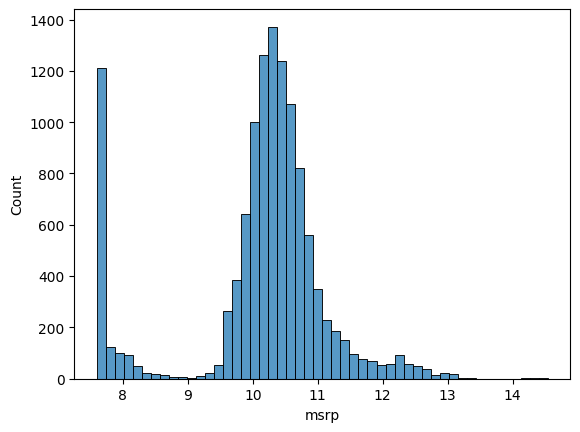

In [35]:
sns.histplot(price_logs, bins=50);

## train test split

In [47]:
n = len(df)

idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)

n_vl = int(n*0.2)
n_ts = int(n*0.2)
n_tr = n - n_vl - n_ts

df_tr = df.iloc[idx[:n_tr]].reset_index(drop=True)
df_vl = df.iloc[idx[n_tr:n_tr+n_vl]].reset_index(drop=True)
df_ts = df.iloc[idx[n_tr+n_vl:]].reset_index(drop=True)


print(df_tr.shape,  df_vl.shape, df_ts.shape)

(7150, 16) (2382, 16) (2382, 16)


In [48]:
ytr = np.log1p(df_tr.msrp.values)
yvl = np.log1p(df_vl.msrp.values)
yts = np.log1p(df_ts.msrp.values)
print(ytr.shape, yvl.shape, yts.shape)

(7150,) (2382,) (2382,)


In [49]:
del df_tr["msrp"]
del df_vl["msrp"]
del df_ts["msrp"]

## baseline model

In [51]:
def train_linear_regresion(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack((ones, X))
    
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]

In [60]:
base = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'popularity']

Xtr = df_tr[base].fillna(0).values

In [62]:
w0, w = train_linear_regresion(Xtr, ytr)

In [64]:
ypr = w0+ Xtr.dot(w)

<Axes: ylabel='Count'>

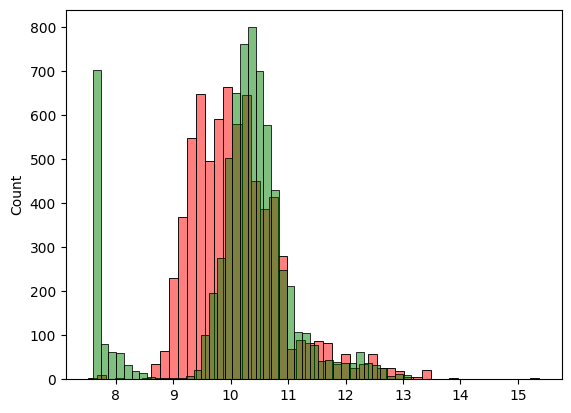

In [65]:
sns.histplot(ypr, color='r', bins=50, alpha=0.5)
sns.histplot(ytr, color='g', bins=50, alpha=0.5)

## RMSE

In [66]:
def rmse(y, ypr):
    error = y - ypr
    se = error ** 2
    mse = se.mean()
    
    return mse**0.5

## validation

In [67]:
def prepare_X(df):
    df_num = df[base]
    df_num = df_num.fillna(0)
    X = df_num.values

    return X

Xtr = prepare_X(df_tr)
w0, w = train_linear_regresion(Xtr, ytr)

Xvl = prepare_X(df_vl)
ypr = w0+ Xvl.dot(w)

print(rmse(yvl, ypr))

0.7398184285113428


## feature engineering

In [71]:
def prepare_X(df): 
    df = df.copy()
    df["age"] = 2017 - df.year
    features = base + ["age"]

    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values

    return X

Xtr = prepare_X(df_tr)
w0, w = train_linear_regresion(Xtr, ytr)

Xvl = prepare_X(df_vl)
ypr = w0+ Xvl.dot(w)

print(rmse(yvl, ypr))

0.5133241025826359


<Axes: ylabel='Count'>

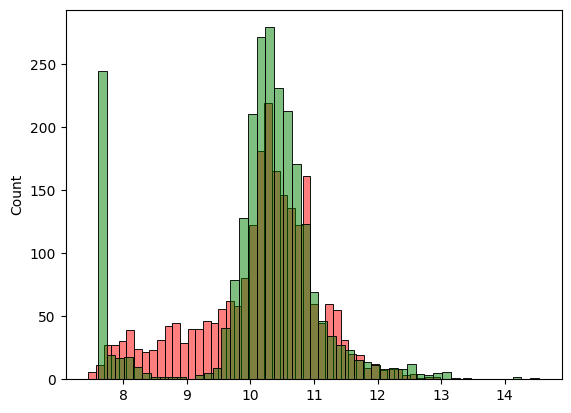

In [74]:
sns.histplot(ypr, color='r', bins=50, alpha=0.5)
sns.histplot(yvl, color='g', bins=50, alpha=0.5)

## categorical vars

In [76]:
def prepare_X(df): 
    df = df.copy()
    features = base.copy()

    df["age"] = 2017 - df.year
    features.append("age")

    for v in [2,3,4]:
        df["num_doors_%s" %v] = (df.number_of_doors == v).astype(int)
        features.append("num_doors_%s" %v)

    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values

    return X

Xtr = prepare_X(df_tr)
w0, w = train_linear_regresion(Xtr, ytr)

Xvl = prepare_X(df_vl)
ypr = w0+ Xvl.dot(w)

print(rmse(yvl, ypr))

0.510823051552939


In [78]:
makes = list(df.make.value_counts().head(5).index)

def prepare_X(df): 
    df = df.copy()
    features = base.copy()

    df["age"] = 2017 - df.year
    features.append("age")

    for v in [2,3,4]:
        df["num_doors_%s" %v] = (df.number_of_doors == v).astype(int)
        features.append("num_doors_%s" %v)

    for v in makes:
        df["make_%s" %v] = (df.make == v).astype(int)
        features.append("make_%s" %v)

    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values

    return X

Xtr = prepare_X(df_tr)
w0, w = train_linear_regresion(Xtr, ytr)

Xvl = prepare_X(df_vl)
ypr = w0+ Xvl.dot(w)

print(rmse(yvl, ypr))

0.5015149550253254


In [79]:
df.columns

Index(['make', 'model', 'year', 'engine_fuel_type', 'engine_hp',
       'engine_cylinders', 'transmission_type', 'driven_wheels',
       'number_of_doors', 'market_category', 'vehicle_size', 'vehicle_style',
       'highway_mpg', 'city_mpg', 'popularity', 'msrp'],
      dtype='object')

In [81]:
categories_variables = ['make', 'engine_fuel_type', 'transmission_type', 'driven_wheels',
              'market_category', 'vehicle_size', 'vehicle_style']

categories = {}

for c in categories_variables:
    categories[c] = list(df[c].value_counts().head().index)

categories

{'make': ['chevrolet', 'ford', 'volkswagen', 'toyota', 'dodge'],
 'engine_fuel_type': ['regular_unleaded',
  'premium_unleaded_(required)',
  'premium_unleaded_(recommended)',
  'flex-fuel_(unleaded/e85)',
  'diesel'],
 'transmission_type': ['automatic',
  'manual',
  'automated_manual',
  'direct_drive',
  'unknown'],
 'driven_wheels': ['front_wheel_drive',
  'rear_wheel_drive',
  'all_wheel_drive',
  'four_wheel_drive'],
 'market_category': ['crossover',
  'flex_fuel',
  'luxury',
  'luxury,performance',
  'hatchback'],
 'vehicle_size': ['compact', 'midsize', 'large'],
 'vehicle_style': ['sedan',
  '4dr_suv',
  'coupe',
  'convertible',
  '4dr_hatchback']}

In [82]:
def prepare_X(df): 
    df = df.copy()
    features = base.copy()

    df["age"] = 2017 - df.year
    features.append("age")

    for v in [2,3,4]:
        df["num_doors_%s" %v] = (df.number_of_doors == v).astype(int)
        features.append("num_doors_%s" %v)

    for c, values in categories.items():
        for v in values:
            df["%s_%s" %(c,v)] = (df[c] == v).astype(int)
            features.append("%s_%s" %(c,v))

    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values

    return X

Xtr = prepare_X(df_tr)
w0, w = train_linear_regresion(Xtr, ytr)

Xvl = prepare_X(df_vl)
ypr = w0+ Xvl.dot(w)

print(rmse(yvl, ypr))

461.26702801305584


## regularization

In [84]:
def train_linear_regresion_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack((ones, X))
    
    XTX = X.T.dot(X)
    XTX = XTX + r + np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]

Xtr = prepare_X(df_tr)
w0, w = train_linear_regresion_reg(Xtr, ytr)

Xvl = prepare_X(df_vl)
ypr = w0+ Xvl.dot(w)

print(rmse(yvl, ypr))

0.4570837573099724


## model tuning

In [85]:
for r in [0.0, 0.00000001, 0.0001, 0.001, 0.01, 1, 10]:
    Xtr = prepare_X(df_tr)
    w0, w = train_linear_regresion_reg(Xtr, ytr, r)

    Xvl = prepare_X(df_vl)
    ypr = w0+ Xvl.dot(w)

    print(r, w0, rmse(yvl, ypr))

0.0 5.571511006732519 0.4570860965889534
1e-08 5.57151129592688 0.4570860965652728
0.0001 5.574401390349087 0.4570858584820884
0.001 5.60029776229452 0.4570837573099724
0.01 5.848171906429364 0.4570665713206514
1 10.809029167754643 0.45783627978036184
10 11.82908026009037 0.45825687149260425


In [86]:
r = 0.001
Xtr = prepare_X(df_tr)
w0, w = train_linear_regresion_reg(Xtr, ytr, r)

Xvl = prepare_X(df_vl)
ypr = w0+ Xvl.dot(w)

print(r, w0, rmse(yvl, ypr))

0.001 5.60029776229452 0.4570837573099724


## applying the model

In [89]:
df_full_tr = pd.concat([df_tr, df_vl]).reset_index(drop=True)
y_full_tr = np.concatenate([ytr, yvl])

print(df_full_tr.shape, y_full_tr.shape)

(9532, 16) (9532,)


In [91]:
r = 0.001
X_full_tr = prepare_X(df_full_tr)
w0, w = train_linear_regresion_reg(X_full_tr, y_full_tr, r)

Xts = prepare_X(df_ts)
ypr = w0+ Xts.dot(w)

print(rmse(yts, ypr))

0.45013517671097947


In [92]:
car = df_ts.iloc[20].to_dict()
car

{'make': 'toyota',
 'model': 'tacoma',
 'year': 2015,
 'engine_fuel_type': 'regular_unleaded',
 'engine_hp': 236.0,
 'engine_cylinders': 6.0,
 'transmission_type': 'manual',
 'driven_wheels': 'four_wheel_drive',
 'number_of_doors': 4.0,
 'market_category': nan,
 'vehicle_size': 'compact',
 'vehicle_style': 'extended_cab_pickup',
 'highway_mpg': 19,
 'city_mpg': 15,
 'popularity': 2031}

In [95]:
df_car = pd.DataFrame([car])
x_car = prepare_X(df_car)
ypr = w0+ x_car.dot(w)
print(ypr[0])
print(np.expm1(ypr)[0])

10.309711446522265
30021.772214864086


In [98]:
print(np.expm1(yts[20]))

35725.000000000015
